In [1]:
import sys
sys.path.append('./codes/forgraph')
from config import args
import tensorflow as tf
import time
from models import GCN
from metrics import *
import pickle as pkl
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np


In [2]:
with open('./dataset/BA-2motif.pkl','rb') as fin:
    (adjs, feas, labels) = pkl.load(fin)
    
args.early_stop =500

def vis(adj):
    G = nx.from_numpy_matrix(adj)
    pos = nx.kamada_kawai_layout(G)
    nx.draw_networkx_nodes(G, pos)
    nx.draw_networkx_edges(G, pos)

    plt.axis('off')
    plt.show()
    plt.clf()

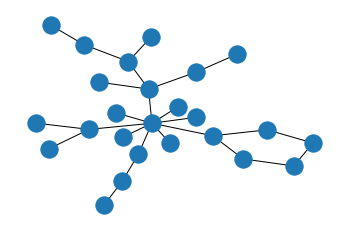

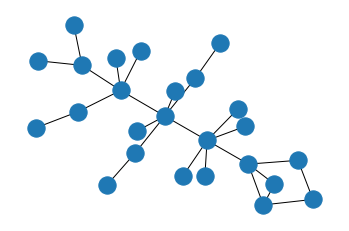

<Figure size 432x288 with 0 Axes>

In [3]:
vis(adjs[0])
vis(adjs[500])

order = np.arange(adjs.shape[0])
shuffle_adjs = adjs[order]
shuffle_feas = feas[order]
shuffle_labels = labels[order]

train_split = int(adjs.shape[0] * 0.8)
val_split = int(adjs.shape[0] * 0.9)

train_adjs = shuffle_adjs[:train_split]
train_feas = shuffle_feas[:train_split]
train_labels = shuffle_labels[:train_split]

val_adjs = shuffle_adjs[train_split:val_split]
val_feas = shuffle_feas[train_split:val_split]
val_labels = shuffle_labels[train_split:val_split]

test_adjs = shuffle_adjs[val_split:]
test_feas = shuffle_feas[val_split:]
test_labels = shuffle_labels[val_split:]


In [ ]:

model = GCN(input_dim=train_feas.shape[-1], output_dim=train_labels.shape[1])

optimizer = tf.keras.optimizers.Adam(learning_rate=args.lr)

train_adjs_tensor = tf.convert_to_tensor(train_adjs,dtype=tf.float32)
train_features_tensor = tf.convert_to_tensor(train_feas,dtype=tf.float32)
train_labels_tensor = tf.convert_to_tensor(train_labels,dtype=tf.float32)

val_adjs_tensor = tf.convert_to_tensor(val_adjs,dtype=tf.float32)
val_features_tensor = tf.convert_to_tensor(val_feas,dtype=tf.float32)
val_labels_tensor = tf.convert_to_tensor(val_labels,dtype=tf.float32)

test_adjs_tensor = tf.convert_to_tensor(test_adjs,dtype=tf.float32)
test_features_tensor = tf.convert_to_tensor(test_feas,dtype=tf.float32)
test_labels_tensor = tf.convert_to_tensor(test_labels,dtype=tf.float32)

best_test_acc = 0
best_val_acc = 0
best_val_loss = 10000
clip_value_min = -2.0
clip_value_max = 2.0
best_train_acc = 0

curr_step = 0
for epoch in range(args.epochs):
    if args.batch:
        begin = 0
        batch_size= 64
        end = batch_size
        trainsize = train_adjs.shape[0]
        outputs = []
        while begin<trainsize:
            batch_train_adjs_tensor = tf.convert_to_tensor(train_adjs[begin:end], dtype=tf.float32)
            batch_train_features_tensor = tf.convert_to_tensor(train_feas[begin:end], dtype=tf.float32)
            batch_train_labels_tensor = tf.convert_to_tensor(train_labels[begin:end], dtype=tf.float32)

            with tf.GradientTape() as tape:
                output = model.call((batch_train_features_tensor,batch_train_adjs_tensor),training=True)
                cross_loss = softmax_cross_entropy(output, batch_train_labels_tensor)
                lossL2 = tf.add_n([tf.nn.l2_loss(v) for v in model.trainable_variables])
                loss = cross_loss + args.weight_decay*lossL2
                grads = tape.gradient(loss, model.trainable_variables)
                cliped_grads = [tf.clip_by_value(t, clip_value_min, clip_value_max) for t in grads]
            optimizer.apply_gradients(zip(cliped_grads, model.trainable_variables))
            begin = end
            end = min(end+batch_size,trainsize)
            outputs.append(output)
        output = tf.concat(outputs,axis=0)
    else:
        with tf.GradientTape() as tape:
            output = model.call((train_feas_tensor,train_adjs_tensor),training=True)
            cross_loss = softmax_cross_entropy(output, train_labels_tensor)
            lossL2 = tf.add_n([tf.nn.l2_loss(v) for v in model.trainable_variables])
            loss = cross_loss + args.weight_decay*lossL2
            grads = tape.gradient(loss, model.trainable_variables)
            cliped_grads = [tf.clip_by_value(t, clip_value_min, clip_value_max) for t in grads]
        optimizer.apply_gradients(zip(cliped_grads, model.trainable_variables))

    train_acc = accuracy(output, train_labels_tensor)
    val_output = model.call((val_features_tensor, val_adjs_tensor), training=False)
    val_acc  = accuracy(val_output, val_labels_tensor)
    val_loss = softmax_cross_entropy(val_output, val_labels_tensor)
    
    

    test_output = model.call((test_features_tensor, test_adjs_tensor), training=False)
    test_acc  = accuracy(test_output, test_labels_tensor)
    test_loss = softmax_cross_entropy(test_output, test_labels_tensor)

    if val_acc > best_val_acc or (train_acc > best_train_acc and best_val_acc==val_acc):
        curr_step = 0
        best_test_acc = test_acc
        best_val_acc = val_acc
        best_val_loss= val_loss
        if args.save_model:
            model.save_weights(args.save_path+args.dataset)
    else:
        curr_step +=1
    if curr_step > args.early_stop:
        print("Early stopping...")
        break
    if train_acc > best_train_acc:
        best_train_acc = train_acc
            
    

    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(cross_loss), "train_acc=",
          "{:.5f}".format(train_acc), "val_acc=", "{:.5f}".format(val_acc),
          "test_acc=", "{:.5f}".format(test_acc),
          "test_best_acc=", "{:.5f}".format(best_test_acc)
         )


Epoch: 0001 train_loss= 6.45334 train_acc= 0.62500 val_acc= 0.00000 test_acc= 0.00000 test_best_acc= 0.00000
Epoch: 0002 train_loss= 3.58754 train_acc= 0.62500 val_acc= 0.00000 test_acc= 0.00000 test_best_acc= 0.00000
Epoch: 0003 train_loss= 1.26568 train_acc= 0.62500 val_acc= 0.00000 test_acc= 0.00000 test_best_acc= 0.00000
Epoch: 0004 train_loss= 1.06864 train_acc= 0.62500 val_acc= 0.00000 test_acc= 0.00000 test_best_acc= 0.00000
Epoch: 0005 train_loss= 1.41509 train_acc= 0.62500 val_acc= 0.00000 test_acc= 0.00000 test_best_acc= 0.00000
Epoch: 0006 train_loss= 1.47723 train_acc= 0.62500 val_acc= 0.00000 test_acc= 0.00000 test_best_acc= 0.00000
Epoch: 0007 train_loss= 1.39099 train_acc= 0.62500 val_acc= 0.00000 test_acc= 0.00000 test_best_acc= 0.00000
Epoch: 0008 train_loss= 1.34856 train_acc= 0.62500 val_acc= 0.00000 test_acc= 0.00000 test_best_acc= 0.00000
Epoch: 0009 train_loss= 1.35446 train_acc= 0.62500 val_acc= 0.00000 test_acc= 0.00000 test_best_acc= 0.00000
Epoch: 0010 train_l